## Градиентный бустинг на решающих деревьях

## <font color='blue'>XGBoost</font> eXtreme Gradient Boosting

XGBoost строит композицию из $K$ базовых алгоритмов $b_k$:

$$ \hat{y}_i = \hat{y}_i^{K} = \sum_{k=1}^{K} b_k(x_i) = \hat{y}_i^{\left(K - 1\right)} + b_K(x_i), $$

минимизируя следующий функционал:

$$ Obj = \sum_{i=1}^N \mathcal{L}(y_i, \hat{y}_i ) + \sum_{k=1}^{K} \Omega(b_k),$$

где
 - $N$ — размер обучающей выборки;
 - $x_i, y_i, \hat{y}_i$ — i-ый объект, правильный ответ и предсказание модели для него;
 - $\hat{y}_i^{t}$ — предсказание композиции из $t$ уже обученных базовых алгоритмов для i-го объекта;
 - $\Omega$ — регуляризатор;
 - $\mathcal{L}(y_i, \hat{y}_i)$ — функция потерь.


Функционал, оптимизируемый на $t$-ой итерации:

$$ Obj^{(t)} = \sum_{i=1}^N \mathcal{L}\left(y_i, \hat{y}_i^{(t-1)} + b_t(x_i)\right) + \Omega(b_t).$$

В случае бустинга над решающими деревьями регуляризатор имеет следующий вид:

$$ \Omega(b_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2 + \alpha\sum_{j=1}^{T}w_j,$$

где 
 - $T$ — количество листьев в дереве;
 - $w_j$ — веса в листьях дерева;
 - $\lambda, \alpha, \gamma$ — гиперпараметры.

###  Немного теории


Данный регуляризатор подобран эвристически и хорошо показывает себя на практике. 

Раскладывая в ряд Тейлора выражение $\mathcal{L}\left(y_i, \hat{y}_i^{\left(t-1\right)} + b_t(x_i)\right)$ до второго порядка, получаем:

$$ Obj^{(t)} = \sum_{i=1}^N\left[\mathcal{L}(y_i, \hat{y}_i^{\left(t-1\right)}) + g_{i}b_{t}(x_i) + \frac{1}{2}h_{i}b_{t}^2(x_i)\right] + \Omega(b_t),$$

где $g_i = \partial_{\hat{y}_i^{(t-1)}} \mathcal{L}(y_i, \hat{y_i}^{(t-1)})$, $h_i = \partial_{\hat{y}_i^{(t-1)}}^2 \mathcal{L}(y_i, \hat{y}_i^{(t-1)}) $ — градиент и гессиан оптимизируемой функции потерь.

Приводя теперь подобные слагаемые и отбрасывая слагаемое $ \mathcal{L}(y_i, \hat{y}_i^{(t-1)}) $, не зависящее от $ b_t(x_i)$ (а следовательно, не влияющее на точку минимума функционала), получаем формулу:
$$ Obj^{(t)} \simeq \sum_{j=1}^{T}\left[\sum_{i \in I_j} g_i w_j + \frac{1}{2}\sum_{i \in I_j} (h_i + \lambda)w_j^2\right] + \gamma T$$
$$ = \sum_{j=1}^{T}\left[G_jw_j + \frac{1}{2}(H_j + \lambda)w_j^2\right] + \gamma T, $$

где 
 - $ I_j $ - множество объектов обучающей выборки, попавших в $j$-ый лист дерева;
 - $ G_j = \sum_{i \in I_j} g_i$;
 - $ H_j = \sum_{i \in I_j} h_i$.
 
Теперь, имея заданную структуру дерева, можно аналитически вычислить оптимальные значения для весов:
$$ w_j^* = -\frac{G_j}{H_j + \lambda}.$$

Значение функционала при этом будет равно:

$$ Obj = -\frac{1}{2}\sum_{j=1}^T \frac{G_j^2}{H_j + \lambda} + \gamma T .$$

Осталось только построить дерево оптимальной структуры. Это можно делать известными методами построения решающих деревьев, проводя разбиения таким образом, чтобы максимизировать gain, определенный как уменьшение $Obj$ в момент этого разбиения. Для уже построенного дерева по формулам $ w_j^* $ вычисляются оптимальные значения в листьях.

### https://github.com/dmlc/xgboost

[Установка](https://xgboost.readthedocs.io/en/latest/build.html)

## Пример

Возьмем датасет Boston Housing и обучим XGBoost на нем.

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import numpy as np
from sklearn.datasets import load_boston
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error


rng = np.random.RandomState(31337)

boston = load_boston()
y = boston['target']
X = boston['data']

kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)


#### Преимущества:


* потенциально очень высокое качество во многих задачах

* находит нелинейные связи

* способен обработать датасеты с большим числом объектов и признаков

#### Недостатки:


* очень много параметров

* модели не интерпретируемы

* по умолчанию не очень быстрый

XGBoost предлагает 2 способа использования алгоритмов:
* sklearn-совместимые классы XGBClassifier, XGBRegressor

* "оригинальная" python-библиотека

###  sklearn

In [2]:
for fold_index, (train_index, test_index) in enumerate(kf):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print "RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions)))

RMSE on fold 0: 4.71669323912
RMSE on fold 1: 3.14875583423


### xgboost python

In [3]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["num_boost_round"] = 100
    params["max_depth"] = 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1
    
    return params
    
for fold_index, (train_index, test_index) in enumerate(kf):

    params = get_params()
    
    xgtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    xgtest = xgb.DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain)

    print "RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest))

RMSE on fold 0: [0]	eval-rmse:5.111199
RMSE on fold 1: [0]	eval-rmse:3.336737


## Особенности XGBoost

<font size=3>
Написан на C++, есть обертки на Python, R, Java, Scala

С помощью XGBoost выиграна половина конкурсов на Kaggle

Существует коммерческая версия TreeNet

### Регуляризация

<font size=3>
Для уменьшения переобучения целевая функция поддерживает L0, L1, L2 регуляризации

###  Параллелизм (по признакам)

<img src="http://zhanpengfang.github.io/fig_418/feature_speedup.png" height="600" width="600">

<font size=3>
Также есть возможность запускаться на Hadoop, Spark, Flink и DataFlow

### Кастомные функции потерь / метрики качества

В XGBoost встроено множество различных функций потерь:

* reg:linear

* reg:logistic

* binary:logistic

* binary:logitraw

* multi:softmax

* rank:pairwise

* ...

А также соответствующих eval_metric, которые замеряют качество и позволяют сделать early stop.

Но также имеется возможность реализовать свой objective и eval_metric.

Все, что для этого нужно - уметь считать градиент и гессиан.

In [4]:
def my_reg_linear(preds, dtrain):
    labels = dtrain.get_label()
    grad = (preds - labels)
    hess = np.ones(labels.shape[0])
    return grad, hess

In [5]:
for train_index, test_index in kf:
    params = get_params()
    
    xgtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    xgtest = xgb.DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, obj=my_reg_linear)
    
    predictions = bst.predict(xgtest)
    actuals = y[test_index]

    print bst.eval(xgtest)

[0]	eval-rmse:5.111199
[0]	eval-rmse:3.336737


### Approximated tree splitting

Если данных слишком много, то можно использовать не все значения признаков, а разделить их на бакеты.

А именно, от каждого признака берутся не все значения, а только некоторое подмножество. Разбиение производится по элементам этого подмножества. 

Для разбиения выбираются взвешенные перцентили.

В оригинальной статье указывается 2 алгоритма:
*   глобальный - один раз выбрать разбиение значений фактора перед началом построения дерева и зафиксировать

    экономим на выборе разбиений, но обычно приходится выбирать больше точек разбиения
    
    
*   локальный - выбирать разбиение после каждого сплита
  
    работает лучше на глубоких деревьях

In [6]:
params["tree_method"] = "approx"
params["sketch_eps"] = 0.2

### Пропуски в данных

XGBoost умеет обрабатывать разреженные матрицы

Но категориальные признаки нужно приводить к числовому виду

Нужно указать, какое число является "пропуском"

При сплите, алгоритм смотрит в какую сторону лучше отвести объекты с пропуском.

In [7]:
xgtrain_missed = xgb.DMatrix(X[test_index], label=y[test_index], missing=-999.0)

### Feature importances

Подсчитывает сколько раз каждый признак использовался для использовался в вершине дерева при разбиении

Это не качество фактора, а его важность

In [8]:
bst.get_fscore()

{'f0': 9,
 'f10': 5,
 'f12': 15,
 'f3': 1,
 'f4': 8,
 'f5': 12,
 'f6': 3,
 'f7': 8,
 'f9': 3}

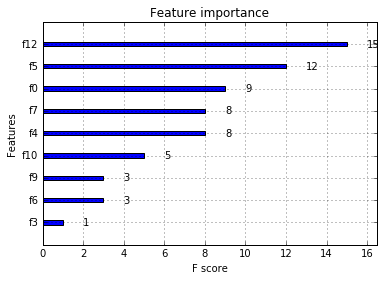

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
xgb.plot_importance(bst)

###  Tree Plotting

Для наглядности можно отрисовать отдельное дерево. На ребрах также написано дефолтное направление для данных с пропусками

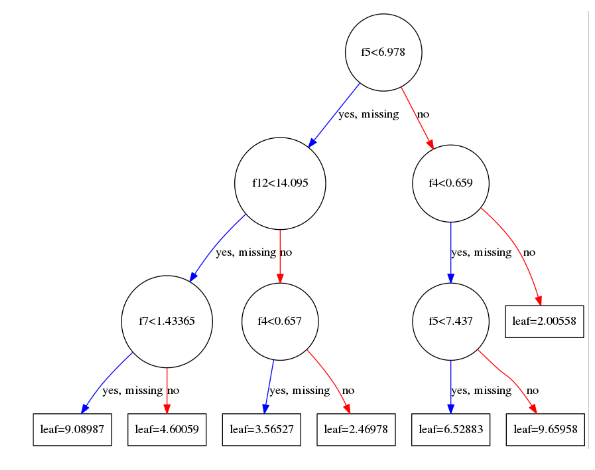

In [16]:
_, ax = plt.subplots(figsize=(10, 10))
xgb.plot_tree(bst, num_trees=1, ax=ax)

### Прунинг

Обычно GBM перестает разделять вершины дерева, когда gain становится отрицательным - жадный подход.
Могло оказаться так, что после неудачного сплита с отрицательным gain'ом получится сделать сильно положительный сплит.

XGBoost доводит деревья до max_depth, после чего начинает удалять сплиты, которые несут отрицательный вклад.

### Дообучение модели

In [11]:
dtrain = xgb.DMatrix('/Users/klunev/xgboost/demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('/Users/klunev/xgboost/demo/data/agaricus.txt.test')
watchlist  = [(dtest,'eval'), (dtrain,'train')]
###
# advanced: start from a initial base prediction
#
print ('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# train xgboost for 1 round
bst = xgb.train( param, dtrain, 1, watchlist )

# Note: we need the margin value instead of transformed prediction in set_base_margin
# do predict with output_margin=True, will always give you margin values before logistic transformation
ptrain = bst.predict(dtrain, output_margin=True)
ptest  = bst.predict(dtest, output_margin=True)

dtrain.set_base_margin(ptrain)
dtest.set_base_margin(ptest)

print ('this is result of running from initial prediction')
bst = xgb.train( param, dtrain, 1, watchlist )

start running example to start from a initial prediction
[0]	eval-error:0.042831	train-error:0.046522
this is result of running from initial prediction
[0]	eval-error:0.021726	train-error:0.022263


**Hint**: в качестве начального приближения можно выбрать предсказания линейной модели

Обратите внимание на *watchlist* - множество выборок для которых мы считаем ошибку. Можно поставить, например, несколько валидационных сетов.
Примеры:
  - time-series prediction: каждая следующая валидационная выборка - новый месяц
  - ranking: ранжирование документов, хотим отслеживать качество на разных типах запросов (разные темы/разные языки и т.д)

### Встроенная кросс валидация

In [12]:
xgb.cv(param, dtrain, nfold = 4, num_boost_round=15)


,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.046530,0.004219,0.046530,0.001407
1,0.022267,0.002827,0.022267,0.000942
2,0.007064,0.001408,0.007064,0.000469
3,0.015203,0.001811,0.015203,0.000603
4,0.007064,0.001408,0.007064,0.000469
5,0.001997,0.001097,0.001945,0.001370
6,0.001228,0.000615,0.001228,0.000205
7,0.001228,0.000615,0.001228,0.000205
8,0.001228,0.000615,0.001228,0.000205
9,0.001075,0.000798,0.000870,0.000529


### Overfitting

  - regularization
  - subsampling
  - shrinkage
  - early stopping

<img src="https://i.imgur.com/mlFHAw2.png" height="600" width="600">


## Early stopping

 Параметры xgb.train, необходимые для early stopping
   - early_stopping_rounds
   - evals



### Веса для объектов

Мы можем учитывать каждый объект со своим весом, этот вес будет учитываться и при выборе бакетов при приближенном построении деревьев, при сплите, при подсчете Objective.

Допустим, мы хотим классифицировать короткие сообщения.  Некоторые из них повторяются. В этом случае выгодно "слить" вместе все дубликаты и посчитать их один раз, но с большим весом. При неизменном качестве это уменьшит время обучения 

In [13]:
repeats = np.random.randint(low=1, high=5, size=X.shape[0])
train_examples = 300


X_train = X[:train_examples]
X_test = X[train_examples:]
y_train = y[:train_examples]
y_test = y[train_examples:]


X_train_repeated = np.repeat(X_train, repeats[:train_examples], axis=0)
X_test_repeated = np.repeat(X_test, repeats[train_examples:], axis=0)
y_train_repeated = np.repeat(y_train, repeats[:train_examples], axis=0)


xgtrain_repeated = xgb.DMatrix(X_train_repeated, label=y_train_repeated)
xgtrain_weighted = xgb.DMatrix(X_train, label=y_train, weight=repeats[:train_examples])

xgtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(params, xgtrain_repeated)
print "Repeated dataset. Train size: {}, error: {}".format(xgtrain_repeated.num_row(), bst.eval(xgtest))

bst = xgb.train(params, xgtrain_weighted)
print "Weighted dataset. Train size: {}, error: {}".format(xgtrain_weighted.num_row(), bst.eval(xgtest))


Repeated dataset. Train size: 739, error: [0]	eval-rmse:6.220294
Weighted dataset. Train size: 300, error: [0]	eval-rmse:6.220294


### 3 вида бустеров

* gbtree - обычные решающие деревья

* gblinear - линейные модели

* dart - решающие деревья, алгоритм может "выбрасывать" некоторые из деревьев, уменьшая переобучение


###  Алгоритм	Viola-Jones


Обнаружение объектов (обычно лиц) в реальном времени


<img src="http://farm8.staticflickr.com/7205/6884354620_49503b7c3a_z.jpg">

  - различных признаков очень много
  - используется вариация AdaBoost'a

# Другие параметры

### Бустинг

<i> learning_rates </i> - можно настроить убывающую скорость

### Параметры деревьев

<font size=3>
<i> max_depth </i> - максимальная глубина дерева. Слишком большая глубина ведет к переобучению

<i> subsample, colsample_bytree, colsample_bylevel </i> - сэмплирование по объектам и признакам


<i> min_child_weight </i> - минимальная сумма весов в листе

<i> scale_pos_weight </i> - вес целого класса, используется если один класс заметно чаще встречается, чем другой


### Дополнительные параметры для DART

<font size=3>
<i> sample_type </i> - стратегия выбора деревьев для выкидывания

<i> rate_drop </i> - какую долю выкидываем

<i> skip_drop </i> - шанс пропустить дроп на этой итерации

# Настраиваем XGBoost 

<font size=3>
* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев